# Quantum Measurements

**Measurement** means projecting a quantum state onto the eigenstates of an observable, yielding **classical outcomes**.

If we measure $|\psi\rangle$ in the eigenbasis of an observable $O$ with eigenvalues $\lambda_i$, the outcome is one of the $\lambda_i$ with probability

$$
p_i = |\langle \psi | \phi_i \rangle|^2,
$$

where $|\phi_i\rangle$ are the eigenstates of $O$.

An observable is a **Hermitian operator**, which has real eigenvalues and orthogonal eigenstates. It can be represented via **spectral decomposition** as:

$$
O = \sum_i \lambda_i |\phi_i\rangle \langle \phi_i|.
$$

Mathematically **applying** $O$ to $|\psi\rangle$ is a linear algebra operation that expresses the state as a combination of its eigenstates weighted by $\lambda_i$. This does **not** collapse the state — it remains a valid quantum state vector in superposition.

In **Qiskit terms**:

* **Statevector / probabilities / expectation values** are *pre-measurement concepts*:
  they come from the amplitudes of $|\psi\rangle$ and are computed deterministically without collapse.
* **Sampling / counts** simulate or perform *physical measurement*:
  each shot prepares $|\psi\rangle$, projects it onto an eigenstate, and records the result. The original state is destroyed for that shot, so repeated preparation is needed.

Thus, expectation values tell us the *average result we would get* if we measured many times, while sampling gives us *one possible set of outcomes* from actually doing those measurements.

## Pauli Operators and Measurements

Pauli $X, Y, Z$ have **two related but distinct roles**:

### 1. **Mathematical operators (observables)**

* $X, Y, Z$ are $2\times 2$ Hermitian matrices — the **Pauli operators**.
* As **observables**, they define **measurement axes** on the Bloch sphere:

  * **Z**: vertical axis ($|0\rangle, |1\rangle$ basis)
  * **X**: horizontal axis ($|+\rangle, |-\rangle$ basis)
  * **Y**: depth axis ($|+i\rangle, |-i\rangle$ basis)
* Example: $Z \otimes Z$ means “measure both qubits in the Z basis, assign each result ±1, then multiply them” — used for correlations and expectation values.
* Applying an observable in math (e.g., $Z|\psi\rangle$) **does not** perform a physical measurement — it’s just linear algebra for computing probabilities or expectation values.

### 2. **Physical measurement axes**

* “Measure in X basis” means measure the **observable** $X$, whose eigenstates are $|+\rangle, |-\rangle$.
* “Measure in Y basis” means measure $Y$, whose eigenstates are $|+i\rangle, |-i\rangle$.
* Hardware typically measures only in the Z basis.
  To measure in X or Y, **rotate first** so that the desired axis aligns with Z:

  * **X basis**: apply $H$ before Z measurement.
  * **Y basis**: apply $S^\dagger$ then $H$ (or equivalently $RY(-\pi/2)$) before Z measurement.

### 3. **Gates vs. measurements in Qiskit**

* In Qiskit, `qc.z(0)` applies a **Z gate** (unitary phase flip), not a measurement.
* **Measurement** is done with `.measure()` or `.measure_all()`, optionally preceded by pre-rotations for non-Z axes.

| Symbol | Gate meaning                | Measurement meaning     |
| ------ | --------------------------- | ----------------------- |
| $Z$    | Phase-flip unitary          | Observable along Z axis |
| $X$    | Bit-flip unitary            | Observable along X axis |
| $Y$    | Combined flip/phase unitary | Observable along Y axis |

**Key takeaway:**

* **Pauli observables** define the **axis and eigenstates** for measurement.
* **Statevector, probabilities, and expectation values** are *pre-measurement* concepts: computed from amplitudes without collapse.
* **Sampling / counts** in Qiskit simulate *physical measurement*: each shot collapses the state and yields a classical outcome.
* To measure in X or Y, rotate into the Z basis first, then measure normally.

In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram


backend = AerSimulator()

# A helper to show the state of a circuit in Dirac notation
def show_state_dirac(qc):
    state = Statevector.from_instruction(qc)
    display(qc.draw('mpl'))
    display(state.draw('latex'))

# A helper to run a circuit and plot results
def run_and_plot(qc, shots=1024, title=None):
    compiled = transpile(qc, backend=backend)
    job = backend.run(compiled, shots=shots)
    result = job.result()
    counts = result.get_counts()
    display(qc.draw('mpl'))
    display(plot_histogram(counts, title=title))

## Example 1: Measure |+⟩ in Z basis

This example shows how to measure the state |+⟩ in the Z basis, which will yield either |0⟩ or |1⟩ with equal probability.

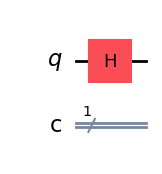

<IPython.core.display.Latex object>

Measuring in Z basis (should be 0 with ~50% probability):


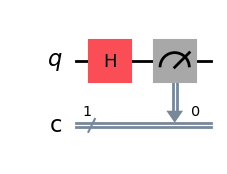

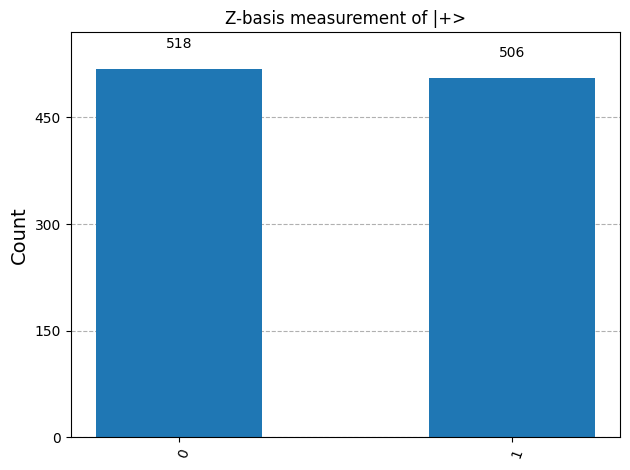

In [2]:
# prepare |+⟩
qc_z = QuantumCircuit(1, 1)
qc_z.h(0)

show_state_dirac(qc_z)

# measure in Z basis
qc_z.measure(0, 0)

print("Measuring in Z basis (should be 0 with ~50% probability):")
run_and_plot(qc_z, title="Z-basis measurement of |+>")

## Example 2: Measure |+⟩ in X basis

This example shows how to measure the state |+⟩ in the X basis, which will yield either |0⟩ for most of the time since the state is aligned with the X axis.

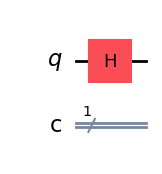

<IPython.core.display.Latex object>

Measuring |+> in X basis:


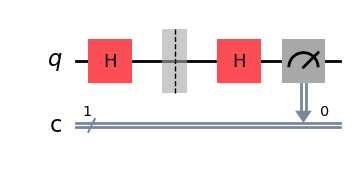

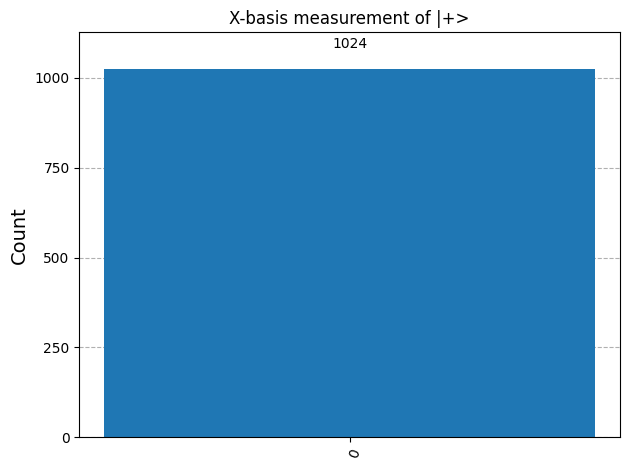

In [3]:
# prepare |+⟩
qc_x = QuantumCircuit(1, 1)
qc_x.h(0)

show_state_dirac(qc_x)
qc_x.barrier()

# rotate X axis to Z axis and measure in Z basis
qc_x.h(0)
qc_x.measure(0, 0)

print("Measuring |+> in X basis:")
run_and_plot(qc_x, title="X-basis measurement of |+>")

## Example 3a: Measure |+i⟩ in Y via Sdg + H (deterministic)

This example shows how to measure the state |+i⟩ in the Y basis using the Sdg gate followed by H, which will yield |0⟩ with high probability (deterministic when there is no noise).

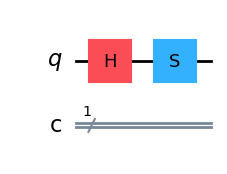

<IPython.core.display.Latex object>

Measuring |+i> in Y via Sdg+H (should be all 0):


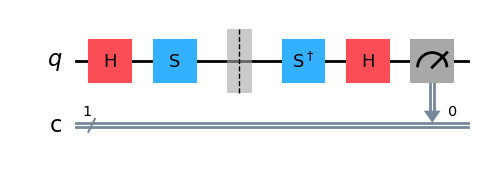

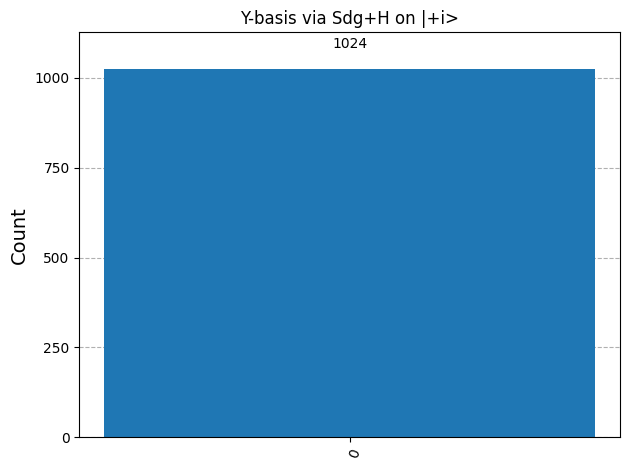

In [4]:
# prepare |+i⟩
qc_y1 = QuantumCircuit(1, 1)
qc_y1.h(0)           # |+>
qc_y1.s(0)           # |+i>  (on +Y)

show_state_dirac(qc_y1)
qc_y1.barrier()

# rotate Y axis to X axis and Z axis, then measure in Z basis
qc_y1.sdg(0)         # pre-rotate Y -> X
qc_y1.h(0)           # pre-rotate X -> Z
qc_y1.measure(0, 0)  # Z measurement ≡ Y-basis measurement of original state

print("Measuring |+i> in Y via Sdg+H (should be all 0):")
run_and_plot(qc_y1, title="Y-basis via Sdg+H on |+i>")

## Example 3c: Measure |+⟩ in Y (should be ~50/50)

This example shows how to measure the state |+⟩ in the Y basis using the Sdg gate followed by H, which will yield |0⟩ and |1⟩ with equal probability (50/50).

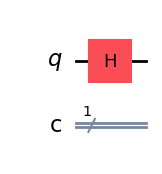

<IPython.core.display.Latex object>

Measuring |+> in Y (should be ~50/50):


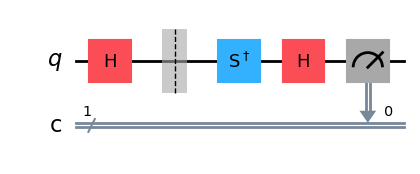

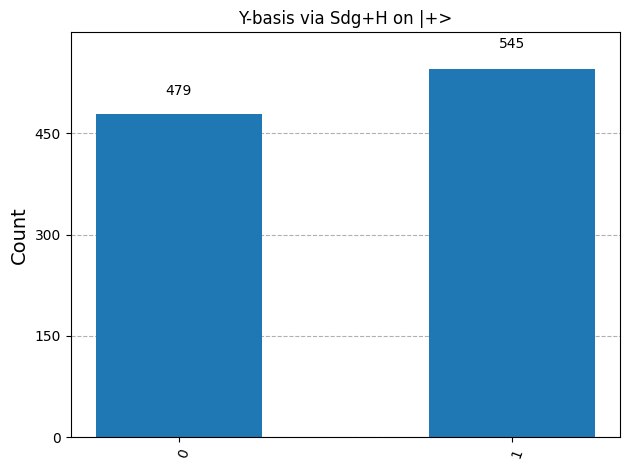

In [5]:
# prepare |+⟩
qc_y3 = QuantumCircuit(1, 1)
qc_y3.h(0)           # |+> (on +X)

show_state_dirac(qc_y3)
qc_y3.barrier()

# rotate Y axis to X axis and Z axis, then measure in Z basis
qc_y3.sdg(0)
qc_y3.h(0)  # Y-basis measurement via Sdg+H
qc_y3.measure(0, 0)

print("Measuring |+> in Y (should be ~50/50):")
run_and_plot(qc_y3, title="Y-basis via Sdg+H on |+>")

## Measurements in Multi-Qubit States

### Bell states give perfect correlation in the same basis

For the Bell states, 
$$
|\Phi^+\rangle = \frac{1}{\sqrt{2}} (|00\rangle + |11\rangle)
$$

measuring both qubits in the same basis always gives matching results.

That's because $|\Phi^+\rangle$ is a $+1$ eigenstate of:
$$
Z \otimes Z, \quad X \otimes X, \quad Y \otimes Y
$$

This means:
$$
\begin{aligned}
| Z \otimes Z | \Phi^+ \rangle &= | \Phi^+ \rangle \\
| X \otimes X | \Phi^+ \rangle &= | \Phi^+ \rangle \\
| Y \otimes Y | \Phi^+ \rangle &= | \Phi^+ \rangle
\end{aligned}
$$

As observables, these operators measure the same eigenstate $|\Phi^+\rangle$. 

- ZZ measurement: both qubits collapse to |00⟩ or |11⟩.
- XX measurement: both qubits collapse to |++⟩ or |--⟩.
- YY measurement: both qubits collapse to |+i+i⟩ or |-i-i⟩.

For the other Bell states, the eigenvalue signs change:

| Bell state                                                        | $Z\otimes Z$ | $X\otimes X$ | $Y\otimes Y$ | Interpretation                             |
| ----------------------------------------------------------------- |:------------:|:------------:|:------------:| ------------------------------------------ |
| $\| \Phi^+\rangle = \frac{ \| 00\rangle+ \| 11\rangle}{\sqrt{2}}$ | +1           | +1           | +1           | Perfect **correlation** in all three bases |
| $\| \Phi^-\rangle = \frac{ \| 00\rangle- \| 11\rangle}{\sqrt{2}}$ | +1           | −1           | −1           | Correlated in Z, anti-correlated in X & Y  |
| $\| \Psi^+\rangle = \frac{ \| 01\rangle+ \| 10\rangle}{\sqrt{2}}$ | −1           | +1           | −1           | Correlated in X, Anti-correlated in Z & Y  |
| $\| \Psi^-\rangle = \frac{ \| 01\rangle- \| 10\rangle}{\sqrt{2}}$ | −1           | −1           | +1           | Correlated in Y, Anti-correlated in Z & X  |


In [6]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Pauli
from qiskit_aer import AerSimulator


backend = AerSimulator()

# Prepare a Bell state |Φ+⟩ = (|00⟩ + |11⟩)/√2
qc = QuantumCircuit(2, 2)
qc.h(0)
qc.cx(0, 1)

# Expectation value from statevector (operator picture)
state = Statevector.from_instruction(qc)
observable = Pauli("ZZ")  # Z⊗Z operator
E_statevector = state.expectation_value(observable)
print("E(Z⊗Z) from Statevector =", E_statevector)

# Measure in Z basis
qc.measure([0, 1], [0, 1])

# Run
compiled = transpile(qc, backend)
result = backend.run(compiled, shots=8_192).result()
counts = result.get_counts()

# Compute Z ⊗ Z expectation
def zz_expectation(counts):
    total = 0
    shots = sum(counts.values())
    for bitstring, count in counts.items():
        z0 = 1 if bitstring[1] == '0' else -1  # qubit 0 → rightmost bit
        z1 = 1 if bitstring[0] == '0' else -1  # qubit 1 → leftmost bit
        total += z0 * z1 * count
    return total / shots

E = zz_expectation(counts)
print("E(Z⊗Z) from simulation  =", E)


E(Z⊗Z) from Statevector = 0.9999999999999998
E(Z⊗Z) from simulation  = 1.0



### Measurements along a rotated axis

We can describe a measurement axis in the X-Z plane by an angle $\theta$ from +Z towards +X:
$$
M(\theta) = \cos(\theta) Z + \sin(\theta) X
$$

- $\theta = 0$ corresponds to Z measurement.
- $\theta = \frac{\pi}{2}$ corresponds to X measurement.
- In between, a mixture of X and Z measurements.

### Joint measurement on both qubits

If qubit 0 is measured along $\theta_0$ and qubit 1 along $\theta_1$, the joint measurement operator is:
$$
\begin{aligned}
M(\theta_0) \otimes M(\theta_1) &= (\cos(\theta_0) Z + \sin(\theta_0) X) \otimes (\cos(\theta_1) Z + \sin(\theta_1) X) \\
&= \cos(\theta_0) \cos(\theta_1) Z \otimes Z + \cos(\theta_0) \sin(\theta_1) Z \otimes X + \sin(\theta_0) \cos(\theta_1) X \otimes Z + \sin(\theta_0) \sin(\theta_1) X \otimes X
\end{aligned}
$$

### Expectation value for $|\Phi^+ \rangle$

$$
\begin{aligned}
\langle Z \otimes Z \rangle &= \langle \Phi^+ | Z \otimes Z | \Phi^+ \rangle = 1 \\
\langle X \otimes X \rangle &= \langle \Phi^+ | X \otimes X | \Phi^+ \rangle = 1 \\
\langle Z \otimes X \rangle &= \langle \Phi^+ | Z \otimes X | \Phi^+ \rangle = 0 \\
\langle X \otimes Z \rangle &= \langle \Phi^+ | X \otimes Z | \Phi^+ \rangle = 0
\end{aligned}
$$

Therefore,

$$
\begin{aligned}
\langle M(\theta_0) \otimes M(\theta_1) \rangle &= \cos(\theta_0) \cos(\theta_1) \langle Z \otimes Z \rangle + \cos(\theta_0) \sin(\theta_1) \langle Z \otimes X \rangle + \sin(\theta_0) \cos(\theta_1) \langle X \otimes Z \rangle + \sin(\theta_0) \sin(\theta_1) \langle X \otimes X \rangle \\
&= \cos(\theta_0) \cos(\theta_1) + \sin(\theta_0) \sin(\theta_1) \\
&= \cos(\theta_0 - \theta_1)
\end{aligned}
$$

- If $\theta_0 = \theta_1$, we get perfect correlation: $\langle M(\theta_0) \otimes M(\theta_1) \rangle = 1$.
- If the axes are orthogonal ($\theta_0 - \theta_1 = \frac{\pi}{2}$), we get no correlation: $\langle M(\theta_0) \otimes M(\theta_1) \rangle = 0$.
- Anything in between gives partial correlation.

## Example 4.1: Two-qubit measurements (ZZ)

This example prepares a Bell state |Φ+⟩ = (|00⟩ + |11⟩)/√2 and performs Z–Z measurements on both qubits, which should yield perfect correlation (only 00 and 11).

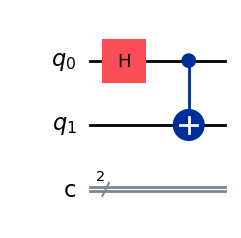

<IPython.core.display.Latex object>

Z–Z measurement (should be perfect correlation: only 00 and 11):


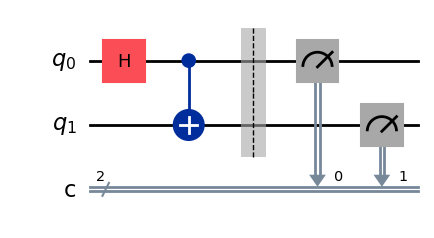

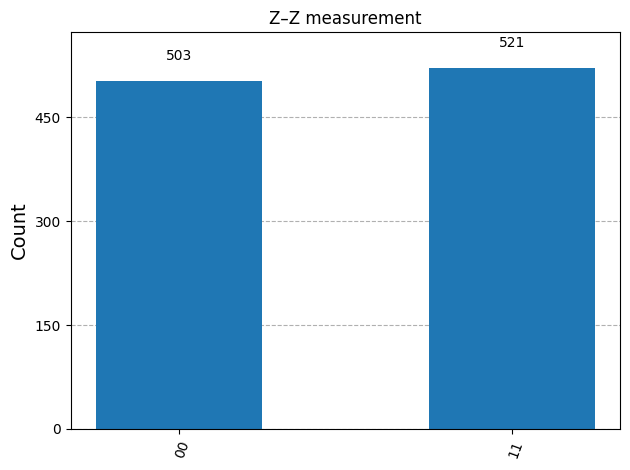

In [7]:
# Prepare Bell state |Φ+> = (|00> + |11>)/√2
qc_4_1 = QuantumCircuit(2, 2)
qc_4_1.h(0)
qc_4_1.cx(0, 1)

show_state_dirac(qc_4_1)
qc_4_1.barrier()

# Z–Z measurement (default)
qc_4_1.measure([0, 1], [0, 1])

print("Z–Z measurement (should be perfect correlation: only 00 and 11):")
run_and_plot(qc_4_1, title="Z–Z measurement")

## Example 4.2: Two-qubit measurements (XX)

This example prepares a Bell state |Φ+⟩ = (|00⟩ + |11⟩)/√2 and performs X–X measurements on both qubits, which should yield perfect correlation (only ++ and -- → 00 and 11).

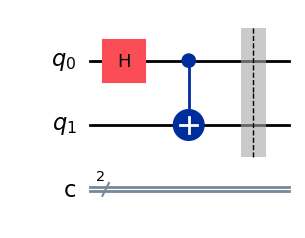

<IPython.core.display.Latex object>

X–X measurement (should be perfect correlation: only ++ and -- → 00 and 11):


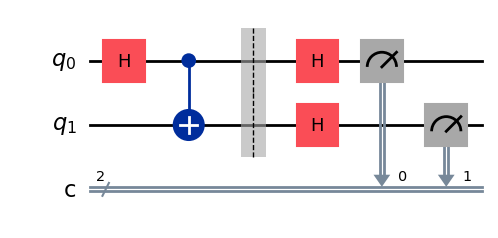

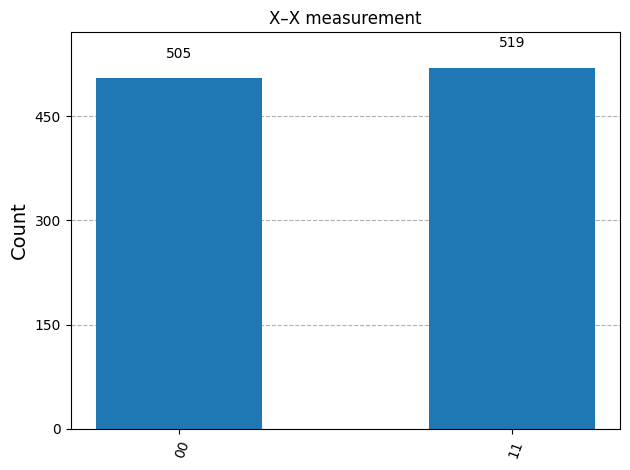

In [8]:
# Prepare Bell state |Φ+> = (|00> + |11>)/√2
qc_4_2 = QuantumCircuit(2, 2)
qc_4_2.h(0)
qc_4_2.cx(0, 1)
qc_4_2.barrier()

show_state_dirac(qc_4_2)

# X–X measurement: rotate both qubits with H
qc_4_2.h([0, 1])
qc_4_2.measure([0, 1], [0, 1])

print("X–X measurement (should be perfect correlation: only ++ and -- → 00 and 11):")
run_and_plot(qc_4_2, title="X–X measurement")

## Example 4.3: Two-qubit measurements (XZ)

This example prepares a Bell state $|\Phi^+\rangle = (|00\rangle + |11\rangle)/\sqrt{2}$ and performs X–Z measurements on both qubits, which should yield no correlation (00, 01, 10, 11 all ~25%).

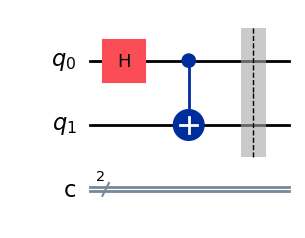

<IPython.core.display.Latex object>

X–Z measurement (should be no correlation — 00,01,10,11 all ~25%):


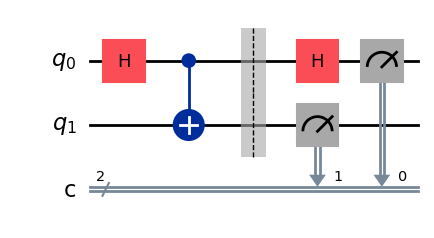

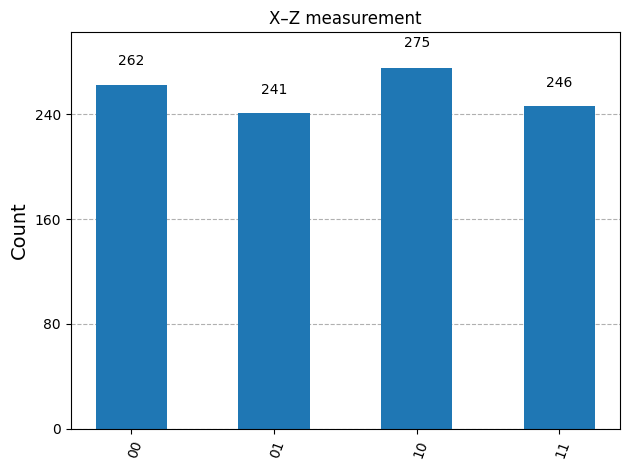

In [9]:
# Prepare Bell state |Φ+> = (|00> + |11>)/√2
qc_4_3 = QuantumCircuit(2, 2)
qc_4_3.h(0)
qc_4_3.cx(0, 1)
qc_4_3.barrier()

show_state_dirac(qc_4_3)

# X–Z measurement: H on qubit 0 only
qc_4_3.h(0)
qc_4_3.measure([0, 1], [0, 1])

print("X–Z measurement (should be no correlation — 00,01,10,11 all ~25%):")
run_and_plot(qc_4_3, title="X–Z measurement")

## Example 5: Measurements of an arbitrary state in an arbitrary basis

Suppose our 2-qubit pure state is

$$
|\psi\rangle=\alpha|00\rangle+\beta|01\rangle+\gamma|10\rangle+\delta|11\rangle,\quad
(|\alpha|^2+|\beta|^2+|\gamma|^2+|\delta|^2=1).
$$

Pick an arbitrary **measurement axis** on the Bloch sphere for the **first qubit** (the right-hand one). 

Any orthonormal axis can be written with angles $\theta\in[0,\pi],\ \phi\in[0,2\pi)$:

$$
|n{+}\rangle=\cos\frac{\theta}{2}\,|0\rangle+e^{i\phi}\sin\frac{\theta}{2}\,|1\rangle,\quad
|n{-}\rangle=\sin\frac{\theta}{2}\,|0\rangle-e^{i\phi}\cos\frac{\theta}{2}\,|1\rangle.
$$

The probability to get the **“+” outcome** when measuring the first qubit along that axis is

$$
P_{n+}=\big\|\ (\mathbb{I}\otimes\langle n{+}|)\,|\psi\rangle\ \big\|^2.
$$

Expanding it gives a compact formula in terms of the amplitudes:

$$
P_{n+}
=\underbrace{\Big\|\ \alpha\cos\frac{\theta}{2}+\beta\,e^{-i\phi}\sin\frac{\theta}{2}\ \Big\|^2}_{\text{left qubit = 0}}
+\underbrace{\Big\|\ \gamma\cos\frac{\theta}{2}+\delta\,e^{-i\phi}\sin\frac{\theta}{2}\ \Big\|^2}_{\text{left qubit = 1}}.
$$

Here, the original amplitudes are already for a **normalized** state ($|\alpha|^2 + |\beta|^2 + |\gamma|^2 + |\delta|^2 = 1$), then $P_{n+} + P_{n-} = 1$ automatically, so no extra normalization is needed.

In [10]:
import numpy as np

def prob_calc_qubit(alpha, beta, gamma, delta, index, theta, phi):
    """
    Probability of '+' outcome when measuring a chosen qubit along axis (theta, phi).

    Qiskit little-endian convention: |q1 q0>
      index = 0 → rightmost ket bit
      index = 1 → leftmost ket bit
    """
    # Normalize state
    psi = np.array([alpha, beta, gamma, delta], dtype=complex)
    psi = psi / np.linalg.norm(psi)
    a, b, g, d = psi

    c = np.cos(theta/2.0)
    s = np.sin(theta/2.0)
    e_minus_i_phi = np.exp(-1j*phi)

    if index == 0:
        # Measuring q0 (rightmost)
        # Slices: left qubit fixed
        overlap0 = c*a + e_minus_i_phi*s*b  # q1=0 slice
        overlap1 = c*g + e_minus_i_phi*s*d  # q1=1 slice
    elif index == 1:
        # Measuring q1 (leftmost)
        overlap0 = c*a + e_minus_i_phi*s*g  # q0=0 slice
        overlap1 = c*b + e_minus_i_phi*s*d  # q0=1 slice
    else:
        raise ValueError("index must be 0 or 1.")

    P_plus = np.abs(overlap0)**2 + np.abs(overlap1)**2
    return float(np.real_if_close(P_plus)), 1.0 - float(np.real_if_close(P_plus))


def prob_qiskit_qubit(alpha, beta, gamma, delta, index, theta, phi):
    # Normalize
    psi = np.array([alpha, beta, gamma, delta], dtype=complex)
    psi /= np.linalg.norm(psi)

    # Build initial state
    sv = Statevector(psi)

    # Pre-rotate chosen qubit so Z-measurement = measurement along (theta,phi)
    # Apply Rz(phi) then Ry(theta)
    from qiskit.circuit.library import RZGate, RYGate
    sv = sv.evolve(RZGate(-phi), [index])
    sv = sv.evolve(RYGate(-theta), [index])

    # Probabilities for Z measurement after rotation
    probs = sv.probabilities([index])  # marginal over the chosen qubit
    return probs  # return P_plus, P_minus


def prob_measure_qubit(alpha, beta, gamma, delta, index, theta, phi):
    calc_p_plus, calc_p_minus = prob_calc_qubit(alpha, beta, gamma, delta, index, theta, phi)
    qiskit_p_plus, qiskit_p_minus = prob_qiskit_qubit(alpha, beta, gamma, delta, index, theta, phi)

    # Ensure both methods give the same result
    print("Calculated probabilities:", calc_p_plus, calc_p_minus)
    print("Qiskit probabilities:", qiskit_p_plus, qiskit_p_minus)

    # Check if both methods give the same result
    if not np.isclose(calc_p_plus, qiskit_p_plus) or not np.isclose(calc_p_minus, qiskit_p_minus):
        raise ValueError("Calculated probabilities do not match Qiskit's results.")
    print("Probabilities match!")

In [11]:
# If first qubit is definitely |0>, measuring along Z (theta=0) should give P_plus=1.
prob_measure_qubit(
    alpha = 1.0,
    beta  = 0.0,
    gamma = 0.0,
    delta = 0.0,
    index = 0,
    theta = 0.0,
    phi   = 0.0)  # (~1.0, ~0.0)

Calculated probabilities: 1.0 0.0
Qiskit probabilities: 1.0 0.0
Probabilities match!


In [12]:
# If first qubit is maximally mixed wrt Z (e.g., |0+>), Z measure gives ~0.5.
prob_measure_qubit(
    alpha = 1/np.sqrt(2),
    beta  = 1/np.sqrt(2),
    gamma = 0.0,
    delta = 0.0,
    index = 0,
    theta = 0.0,
    phi   = 0.0)  # (~0.5, ~0.5)

Calculated probabilities: 0.5000000000000001 0.4999999999999999
Qiskit probabilities: 0.5000000000000001 0.5000000000000001
Probabilities match!


In [13]:
# If we measure along X (theta=pi/2, any phi), and the first qubit is |+>, expect P_plus~1.
prob_measure_qubit(
    alpha = 1/np.sqrt(2),
    beta  = 1/np.sqrt(2),
    gamma = 0.0,
    delta = 0.0,
    index = 0,
    theta = np.pi/2,
    phi   = 0.0)  # (~1.0, ~0.0)

Calculated probabilities: 1.0 0.0
Qiskit probabilities: 1.0 4.6728280004165706e-33
Probabilities match!


In [14]:
# An arbitrary test case
prob_measure_qubit(
    alpha = 1/3,
    beta  = 2/3,
    gamma = 2/3,
    delta = 0.0,
    index = 0,
    theta = np.pi/4,
    phi   = np.pi/5)

Calculated probabilities: 0.6664084662476268 0.33359153375237316
Qiskit probabilities: 0.6664084662476268 0.333591533752373
Probabilities match!
